# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. El objetivo es predecir la cantidad de pedidos de taxis para la próxima hora con el fin de atraer a más conductores durante las horas pico. Para lograrlo, construiremos un modelo de predicción y evaluaremos su precisión utilizando la métrica de RECM (RMSE), que no debe superar los 48 en el conjunto de prueba.

## Instrucciones del proyecto.

1. Descarga los datos y realiza el remuestreo por intervalos de una hora.

2. Analiza los datos para detectar tendencias, estacionalidad y posibles problemas en los datos.

3. Entrena diferentes modelos utilizando varios hiperparámetros. La muestra de prueba debe representar el 10% del conjunto de datos inicial.

4. Evalúa los modelos en el conjunto de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en la ruta `/datasets/taxi.csv`.

La columna `num_orders` representa el número de pedidos de taxis en un intervalo de tiempo determinado.

In [1]:
# Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/datasets/taxi.csv')
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


## Preparación

In [5]:
# Cargar los datos
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

# Convertir el índice a datetime si no lo es
data.index = pd.to_datetime(data.index)

# Remuestrear los datos a intervalos de una hora
data_resampled = data.resample('1H').sum()

data_resampled

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Buen trabajo transformado la columna datetime para agrupar el número de órdenes por hora. 
</div>

<AxesSubplot:xlabel='datetime'>

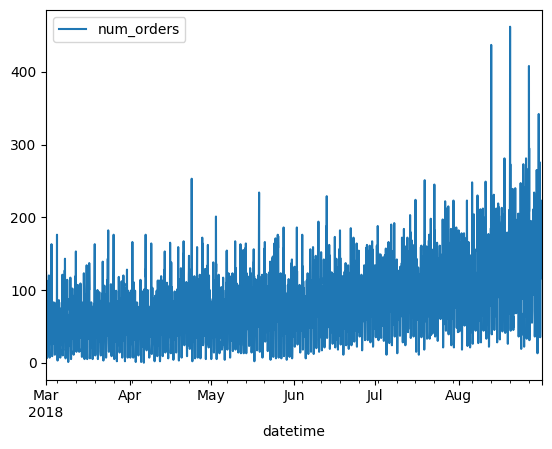

In [6]:
data_resampled.plot()

In [7]:
# Crear las características de desfase y múltiples medias móviles
def make_features(data, max_lag, rolling_mean_sizes):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Crear desfases (lags)
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    
    # Crear múltiples medias móviles con diferentes ventanas
    for size in rolling_mean_sizes:
        data[f'rolling_mean_{size}'] = data['num_orders'].shift(1).rolling(window=size).mean()

# Aplicar la función para crear las características con múltiples medias móviles
make_features(data_resampled, max_lag=15, rolling_mean_sizes=[12, 24, 48])

# Eliminar filas con valores faltantes
data_resampled.dropna(inplace=True)

## Análisis

### Descripción Estadística

In [8]:
# Descripción estadística de los datos
print(data_resampled.describe())

        num_orders    year        month          day         hour  \
count  4368.000000  4368.0  4368.000000  4368.000000  4368.000000   
mean     84.693452  2018.0     5.532967     3.000000    11.500000   
std      45.082131     0.0     1.702330     2.000229     6.922979   
min       0.000000  2018.0     3.000000     0.000000     0.000000   
25%      54.000000  2018.0     4.000000     1.000000     5.750000   
50%      78.000000  2018.0     6.000000     3.000000    11.500000   
75%     108.000000  2018.0     7.000000     5.000000    17.250000   
max     462.000000  2018.0     8.000000     6.000000    23.000000   

             lag_1        lag_2        lag_3        lag_4        lag_5  ...  \
count  4368.000000  4368.000000  4368.000000  4368.000000  4368.000000  ...   
mean     84.663004    84.639194    84.625916    84.611951    84.592033  ...   
std      45.045757    45.000082    44.986691    44.974616    44.971118  ...   
min       0.000000     0.000000     0.000000     0.000000     

###  Verificar Valores Faltantes

In [9]:
# Verificar valores faltantes
print(data_resampled.isna().sum())

num_orders         0
year               0
month              0
day                0
hour               0
lag_1              0
lag_2              0
lag_3              0
lag_4              0
lag_5              0
lag_6              0
lag_7              0
lag_8              0
lag_9              0
lag_10             0
lag_11             0
lag_12             0
lag_13             0
lag_14             0
lag_15             0
rolling_mean_12    0
rolling_mean_24    0
rolling_mean_48    0
dtype: int64


### Visualización de Tendencias

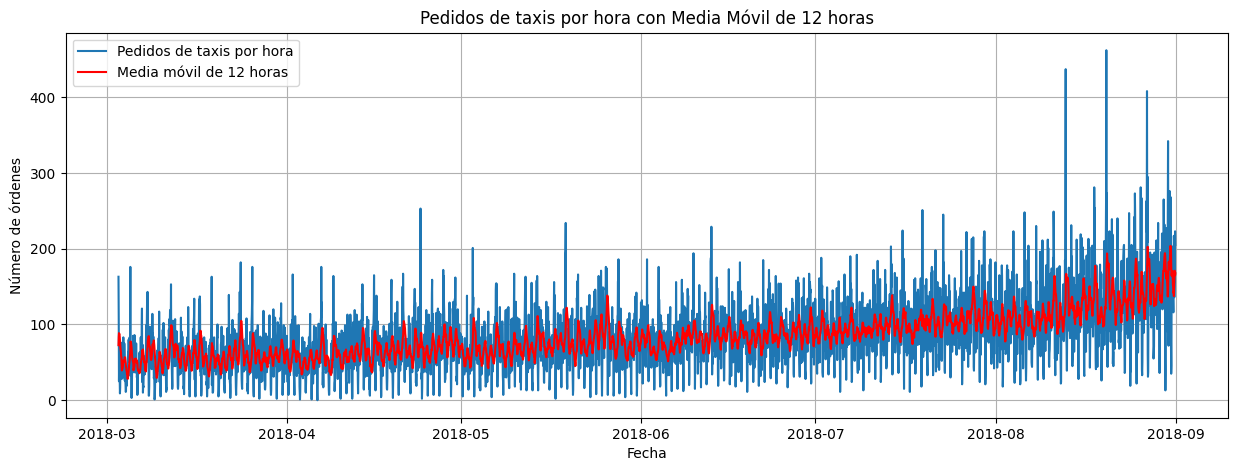

In [10]:
# Graficar la tendencia en los pedidos de taxis por día junto con la media móvil
plt.figure(figsize=(15, 5))
plt.plot(data_resampled.index, data_resampled['num_orders'], label='Pedidos de taxis por hora')
plt.plot(data_resampled.index, data_resampled['rolling_mean_12'], color='red', label='Media móvil de 12 horas')

# Añadir etiquetas y título
plt.title('Pedidos de taxis por hora con Media Móvil de 12 horas')
plt.xlabel('Fecha')
plt.ylabel('Número de órdenes')
plt.legend() 
plt.grid(True)  
plt.show()

Observamos que hay mucho ruido en los datos por lo que volveremos a samplear los datos a un dia.

In [11]:
# Asegúrate de que la columna 'num_orders' está correctamente definida
data_resampled_2 = data.resample('1D').sum()

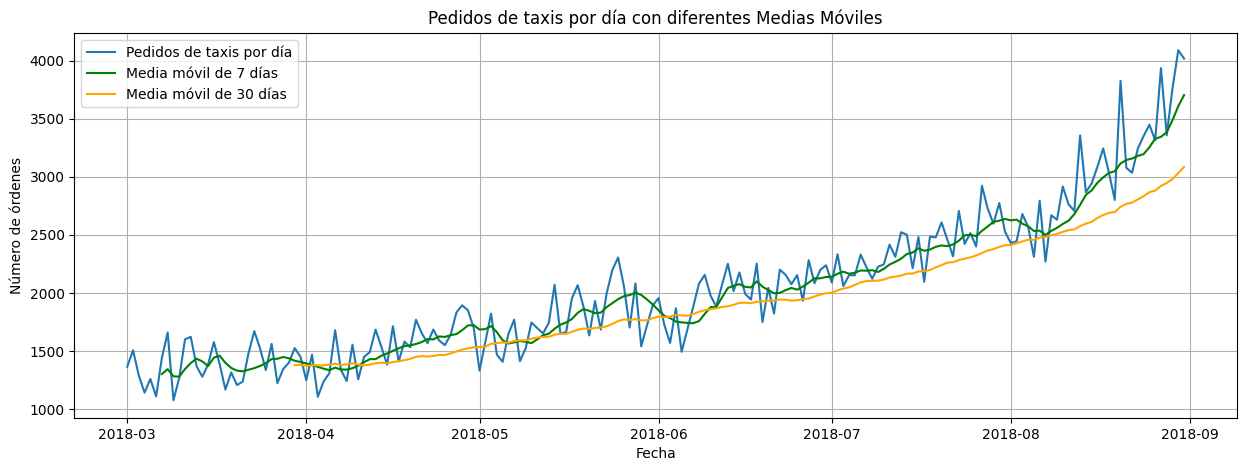

In [15]:
# Calcular medias móviles con diferentes ventanas
data_resampled_2['rolling_mean_7'] = data_resampled_2['num_orders'].rolling(window=7).mean()  # Media móvil semanal
data_resampled_2['rolling_mean_30'] = data_resampled_2['num_orders'].rolling(window=30).mean()  # Media móvil mensual

# Graficar la tendencia en los pedidos de taxis por día junto con diferentes medias móviles
plt.figure(figsize=(15, 5))
plt.plot(data_resampled_2.index, data_resampled_2['num_orders'], label='Pedidos de taxis por día')
plt.plot(data_resampled_2.index, data_resampled_2['rolling_mean_7'], color='green', label='Media móvil de 7 días')
plt.plot(data_resampled_2.index, data_resampled_2['rolling_mean_30'], color='orange', label='Media móvil de 30 días')

# Añadir etiquetas y título
plt.title('Pedidos de taxis por día con diferentes Medias Móviles')
plt.xlabel('Fecha')
plt.ylabel('Número de órdenes')
plt.legend() 
plt.grid(True)  
plt.show()

Observamos una tendencia creciente desde marzo hasta comienzos de septiembre. Veremos cual es la estacionalidad horaria y diaria en los pedidos de taxi.

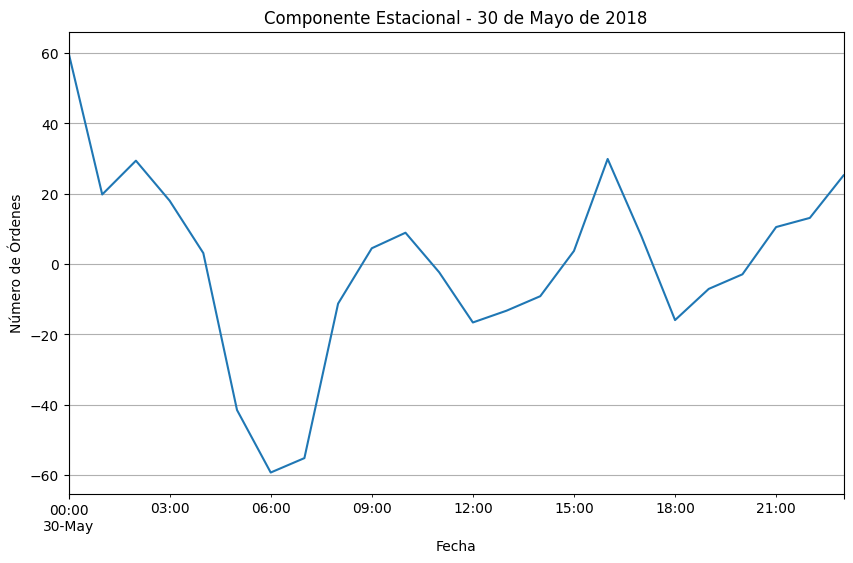

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Agregar una frecuencia explícita
data_resampled = data_resampled.asfreq('H')

# Descomponer la serie temporal remuestreada
decomposed = seasonal_decompose(data_resampled['num_orders'], model='additive')

# Segmentar el componente estacional para el día 30 de Mayo de 2018
seasonal_segment = decomposed.seasonal['2018-05-30']

# Graficar el componente estacional
plt.figure(figsize=(10, 6))
seasonal_segment.plot()
plt.title('Componente Estacional - 30 de Mayo de 2018')
plt.ylabel('Número de Órdenes')
plt.xlabel('Fecha')
plt.grid(True)
plt.show()

Observamos que las ordenes de táxi ocurren principalmente a las 00:00 hrs y a las 16:00hrs.

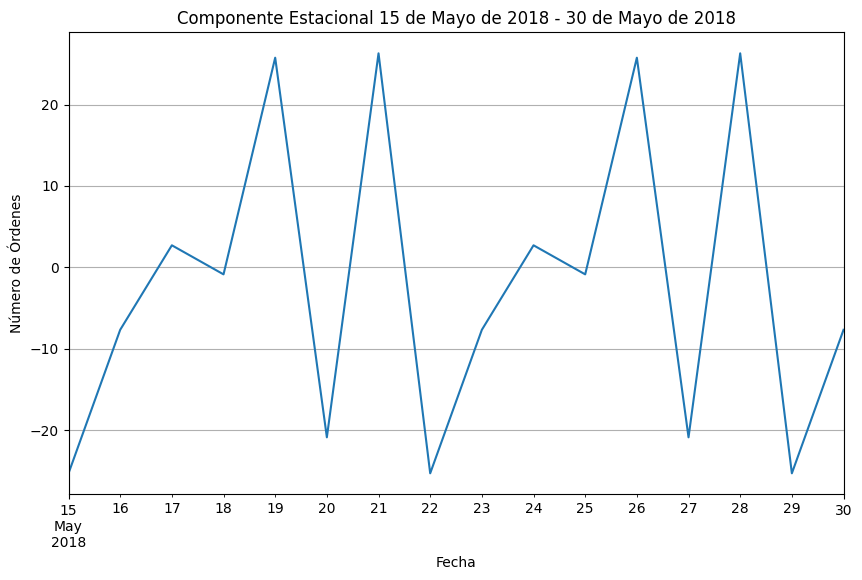

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Agregar una frecuencia explícita
data_resampled_2 = data_resampled.asfreq('D')

# Descomponer la serie temporal remuestreada
decomposed = seasonal_decompose(data_resampled_2['num_orders'], model='additive')

# Segmentar el componente estacional para el día 30 de Mayo de 2018
seasonal_segment = decomposed.seasonal['2018-05-15':'2018-05-30']

# Graficar el componente estacional
plt.figure(figsize=(10, 6))
seasonal_segment.plot()
plt.title('Componente Estacional 15 de Mayo de 2018 - 30 de Mayo de 2018')
plt.ylabel('Número de Órdenes')
plt.xlabel('Fecha')
plt.grid(True)
plt.show()

Por otro lado, al graficar los datos agrupados por día observamos cierta estacionalidad en los datos cada una semana.

## Formación

### División de los Datos

In [18]:
# Dividir los datos en conjuntos de entrenamiento (90%) y prueba (10%) sin mezclar (shuffle=False)
train, test = train_test_split(data_resampled, shuffle=False, test_size=0.1)

# Ahora dividir el conjunto de entrenamiento en entrenamiento y validación (90% - 10%)
train, validation = train_test_split(train, shuffle=False, test_size=0.1)

# Seleccionar las características y el objetivo
features = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 
            'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 
            'rolling_mean_12', 'rolling_mean_24', 'rolling_mean_48', 'year', 'month', 'day', 'hour']

target = 'num_orders'

# Separar los conjuntos en características (X) y objetivo (y)
X_train = train[features]
y_train = train[target]
X_validation = validation[features]
y_validation = validation[target]
X_test = test[features]
y_test = test[target]

### Entrenamiento del Modelo de Regresión Lineal

In [19]:
# Crear y entrenar el modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Realizar predicciones en los conjuntos de entrenamiento y prueba
y_train_pred_linear = linear_model.predict(X_train)
y_test_pred_linear = linear_model.predict(X_test)
y_val_ped_linear = linear_model.predict(X_validation)

### Entrenar el modelo de Random Forest

In [20]:
# Entrenar el modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Realizar predicciones en los conjuntos de entrenamiento y prueba
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)
y_val_pred_rf = rf_model.predict(X_validation)

## Prueba

### Regresión Lineal

In [21]:
# Calcular el RMSE en el conjunto de entrenamiento y prueba
train_rmse_linear = np.sqrt(mean_squared_error(y_train, y_train_pred_linear))
test_rmse_linear = np.sqrt(mean_squared_error(y_test, y_test_pred_linear))
val_rmse_linear = np.sqrt(mean_squared_error(y_validation, y_val_ped_linear))

# Imprimir los valores de RMSE
print(f"RMSE en el conjunto de entrenamiento (Regresión Lineal): {train_rmse_linear:.2f}")
print(f"RMSE en el conjunto de prueba (Regresión Lineal): {test_rmse_linear:.2f}")
print(f"RMSE en el conjunto de validación (Regresión Lineal(): {val_rmse_linear:.2f}")

RMSE en el conjunto de entrenamiento (Regresión Lineal): 28.25
RMSE en el conjunto de prueba (Regresión Lineal): 50.79
RMSE en el conjunto de validación (Regresión Lineal(): 38.67


#### Regresión lineal con ajuste de hiperparametros

In [22]:
from sklearn.linear_model import Ridge

# Definir diferentes valores de alpha para la regularización
alphas = [0.01, 0.1, 1, 10, 100]

best_rmse = float("inf")
best_alpha = None
best_model = None

# Probar cada valor de alpha
for alpha in alphas:
    # Entrenar el modelo de Ridge Regression con el valor actual de alpha
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de validación
    y_val_pred_ridge = ridge_model.predict(X_validation)
    
    # Calcular el RMSE en el conjunto de validación
    val_rmse_ridge = np.sqrt(mean_squared_error(y_validation, y_val_pred_ridge))
    
    # Imprimir los resultados
    print(f"Alpha: {alpha}, RMSE en validación: {val_rmse_ridge:.2f}")
    
    # Guardar el mejor modelo basado en el RMSE más bajo
    if val_rmse_ridge < best_rmse:
        best_rmse = val_rmse_ridge
        best_alpha = alpha
        best_model = ridge_model

# Mostrar el mejor valor de alpha y el RMSE
print(f"Mejor alpha: {best_alpha}, Mejor RMSE en validación: {best_rmse:.2f}")

# Usar el mejor modelo para hacer predicciones en el conjunto de prueba
y_test_pred_ridge_best = best_model.predict(X_test)

# Calcular el RMSE en el conjunto de prueba con el mejor modelo
test_rmse_ridge_best = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge_best))
print(f"RMSE en el conjunto de prueba (Mejor Ridge Regression): {test_rmse_ridge_best:.2f}")

Alpha: 0.01, RMSE en validación: 38.67
Alpha: 0.1, RMSE en validación: 38.67
Alpha: 1, RMSE en validación: 38.67
Alpha: 10, RMSE en validación: 38.67
Alpha: 100, RMSE en validación: 38.67
Mejor alpha: 0.01, Mejor RMSE en validación: 38.67
RMSE en el conjunto de prueba (Mejor Ridge Regression): 50.79


### Random Forest

In [23]:
# Calcular el RMSE en el conjunto de entrenamiento y prueba
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
val_rmse_rf = np.sqrt(mean_squared_error(y_validation, y_val_pred_rf))

# Imprimir los valores de RMSE
print(f"RMSE en el conjunto de entrenamiento (Random Forest): {train_rmse_rf:.2f}")
print(f"RMSE en el conjunto de prueba (Random Forest): {test_rmse_rf:.2f}")
print(f"RMSE en el conjunto de validación (Random Forest): {val_rmse_rf:.2f}")

RMSE en el conjunto de entrenamiento (Random Forest): 13.97
RMSE en el conjunto de prueba (Random Forest): 46.63
RMSE en el conjunto de validación (Random Forest): 31.19


#### Random Forest con ajuste de hiperparametros

In [24]:
# Definir diferentes combinaciones de hiperparámetros con valores individuales
param_grid = [
    {'n_estimators': 100, 'max_depth': 10},
    {'n_estimators': 200, 'max_depth': 15},
    {'n_estimators': 300, 'max_depth': 20}
]

best_rmse = float("inf")
best_params = None
best_model = None

# Probar cada combinación de hiperparámetros

for params in param_grid:
    
    # Entrenar el modelo con los hiperparámetros actuales
    rf_model = RandomForestRegressor(n_estimators=params['n_estimators'], 
                                     max_depth=params['max_depth'], 
                                     random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de validación
    y_val_pred_rf = rf_model.predict(X_validation)
    
    # Calcular el RMSE en el conjunto de validación
    val_rmse_rf = np.sqrt(mean_squared_error(y_validation, y_val_pred_rf))
    
    # Imprimir los resultados
    print(f"Parámetros: {params}, RMSE en validación: {val_rmse_rf:.2f}")
    
    # Guardar el mejor modelo basado en el RMSE más bajo
    if val_rmse_rf < best_rmse:
        best_rmse = val_rmse_rf
        best_params = params
        best_model = rf_model

# Mostrar los mejores hiperparámetros y el RMSE
print(f"Mejores parámetros: {best_params}, Mejor RMSE en validación: {best_rmse:.2f}")

# Usar el mejor modelo para hacer predicciones en el conjunto de prueba
y_test_pred_rf_best = best_model.predict(X_test)

# Calcular el RMSE en el conjunto de prueba con el mejor modelo
test_rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_test_pred_rf_best))
print(f"RMSE en el conjunto de prueba (Mejor Random Forest): {test_rmse_rf_best:.2f}")

Parámetros: {'n_estimators': 100, 'max_depth': 10}, RMSE en validación: 31.19
Parámetros: {'n_estimators': 200, 'max_depth': 15}, RMSE en validación: 31.00
Parámetros: {'n_estimators': 300, 'max_depth': 20}, RMSE en validación: 30.84
Mejores parámetros: {'n_estimators': 300, 'max_depth': 20}, Mejor RMSE en validación: 30.84
RMSE en el conjunto de prueba (Mejor Random Forest): 45.49


## Conclusion

El modelo de `Random Forest` fue el más adecuado para esta tarea. Tras ajustar los hiperparámetros, el modelo alcanzó un `RMSE` de `30.84` en el conjunto de `validación` y un `RMSE` de `45.49` en el conjunto de `prueba`, mejorando significativamente el rendimiento respecto a las versiones sin ajuste.

Por otro lado, el modelo de `Regresión Lineal` tuvo un `RMSE` de `38.67` en `validación` y un `RMSE` de `50.79` en el conjunto de prueba, mostrando un `rendimiento inferior` comparado con `Random Forest`. Aun después de ajustar el modelo utilizando Ridge Regression, los resultados no mejoraron, manteniéndose el RMSE en los mismos valores tanto para validación como para prueba.

El uso de características avanzadas, como los desfases y las medias móviles, fue clave para capturar la estacionalidad y las tendencias temporales, lo que mejoró significativamente el rendimiento de ambos modelos. Sin embargo, `Random Forest`, con sus mejores capacidades de ajuste y predicción, demostró ser superior en esta tarea, mostrando un equilibrio adecuado entre precisión en el entrenamiento y capacidad de generalización en el conjunto de prueba.

## Recomendaciones

__1. Ajustes futuros__: Se podría explorar el ajuste de hiperparámetros adicionales en el modelo de `Random Forest` o probar modelos como `Gradient Boosting` o `XGBoost` para mejorar aún más el rendimiento.

__2. Mayor captura de datos__: Continuar recopilando datos para capturar posibles cambios en los patrones de pedidos de taxis con el tiempo, especialmente durante épocas de mayor demanda como eventos especiales o temporadas de vacaciones.

__3. Monitoreo del modelo__: Implementar un sistema de monitoreo del rendimiento del modelo en producción, asegurándose de que la predicción de pedidos de taxis sea precisa y ajustada a la demanda real.